In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [17]:
from sklearn.datasets import load_wine
import pandas as pd

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [2]:
class StandardScaler:
    """(x - mean) / std"""
    def fit(self, X: np.ndarray):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0, ddof=0)
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean_) / self.std_

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).transform(X)

In [ ]:
class KNN:
    def __init__(self, n_neighbors: int = 5, eps: float = 1e-9):
        self.k = n_neighbors
        self.eps = eps
        self._X = None
        self._y = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self._X = np.asarray(X, dtype=float)
        self._y = np.asarray(y)
        return self

    def _euclidean_distances(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        A2 = np.sum(A*A, axis=1, keepdims=True)
        B2 = np.sum(B*B, axis=1, keepdims=True).T
        d2 = A2 + B2 - 2.0 * (A @ B.T)
        np.maximum(d2, 0, out=d2)
        return np.sqrt(d2, dtype=float)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        dists = self._euclidean_distances(X, self._X)

        idx_k = np.argpartition(
            dists,
            kth=min(self.k, len(self._X)) - 1,
            axis=1
        )[:, :self.k]

        preds = []
        for i in range(X.shape[0]):
            neighbors_idx = idx_k[i]
            neigh_labels = self._y[neighbors_idx]
            neigh_dists = dists[i, neighbors_idx]
            weights = 1.0 / (neigh_dists + self.eps)

            classes, inv = np.unique(neigh_labels, return_inverse=True)
            class_weights = np.zeros(classes.shape[0], dtype=float)
            np.add.at(class_weights, inv, weights)

            pred_label = classes[np.argmax(class_weights)]
            preds.append(pred_label)

        return np.asarray(preds)


In [16]:
wine = load_wine()
X = wine.data
y = wine.target
target_names = wine.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = MyKNN(n_neighbors=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# приведение типов
y_true = np.asarray(y_test).astype(int)
y_hat  = np.asarray(y_pred).astype(int)

print(f"Accuracy (Wine): {accuracy_score(y_true, y_hat):.4f}")
print("\nClassification report:\n",
      classification_report(y_true, y_hat, target_names=target_names, labels=[0,1,2]))
print("Confusion matrix:\n", confusion_matrix(y_true, y_hat, labels=[0,1,2]))


Accuracy (Wine): 0.9444

Classification report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.86      0.92        21
     class_2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54

Confusion matrix:
 [[18  0  0]
 [ 0 18  3]
 [ 0  0 15]]


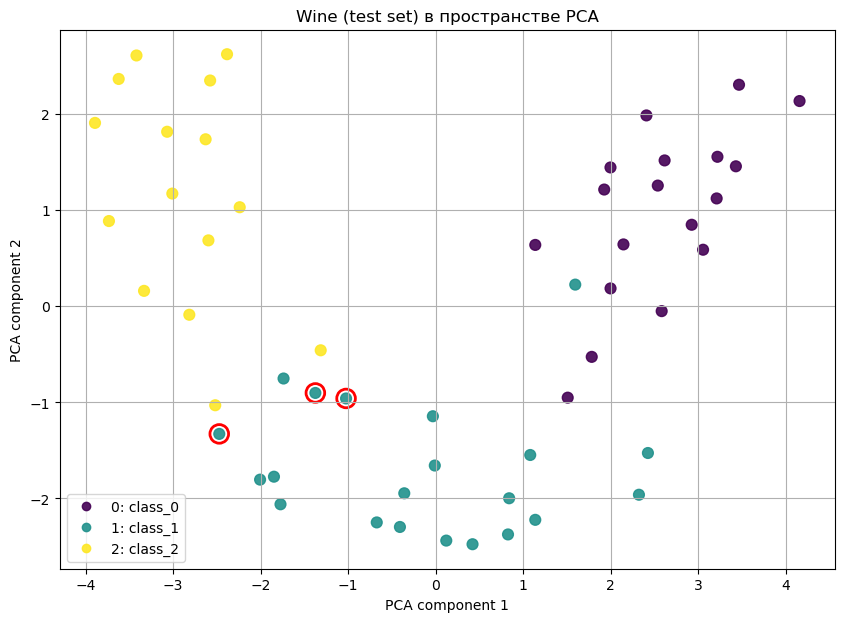

In [5]:
pca = PCA(n_components=2, random_state=42)
Z_test = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(10,7))
scatter = plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_true, s=60, cmap="viridis", alpha=0.9)
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("Wine (test set) в пространстве PCA")
plt.grid(True)

errors = (y_true != y_hat)
plt.scatter(
    Z_test[errors, 0],
    Z_test[errors, 1],
    s=180,
    facecolors="none",
    edgecolors="red",
    linewidths=2,
    label="Ошибки"
)

handles, _ = scatter.legend_elements()
plt.legend(handles, [f"{i}: {name}" for i, name in enumerate(target_names)], loc="best")
plt.show()

In [6]:
for k in [1, 3, 5, 7, 9, 11, 13]:
    model = MyKNN(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred_k = model.predict(X_test_scaled)
    print(f"k={k:>2} -> accuracy: {accuracy_score(y_true, np.asarray(y_pred_k).astype(int)):.4f}")

k= 1 -> accuracy: 0.9630
k= 3 -> accuracy: 0.9444
k= 5 -> accuracy: 0.9444
k= 7 -> accuracy: 0.9444
k= 9 -> accuracy: 0.9630
k=11 -> accuracy: 0.9630
k=13 -> accuracy: 0.9815
